# Importation des librairies

In [1]:
# Suppression des avertissements liés à Scikit-learn
import warnings  # Masquer les avertissements (ex. : FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Librairies générales
import pandas as pd  # Librairie pour la manipulation de données
import numpy as np  # Librairie pour le calcul numérique
import sys  # Fonctions et variables liées à l'interpréteur Python
import copy  # Création de copies d'objets
from numpy import mean, std  # Fonctions de calcul de moyenne et d'écart type
import zipfile  # Traitement de fichiers zip
import os  # Manipulation de fichiers et chemins

# Librairie affichage
import matplotlib.pyplot as plt  # Outils de visualisation 2D
from matplotlib import pyplot  # Interface de la bibliothèque Matplotlib
import seaborn as sns  # Bibliothèque de visualisation de données basée sur Matplotlib

# Scikit-learn pour l'évaluation des modèles
from sklearn.metrics import confusion_matrix  # Matrice de confusion
from sklearn.model_selection import KFold  # Outils de validation croisée
from sklearn.metrics import accuracy_score  # Calcul de l'accuracy
from sklearn.model_selection import train_test_split  # Découpage train/test

# TensorFlow et Keras
import tensorflow as tf  # Librairie de deep learning
import keras  # API haut niveau pour construire et entraîner des modèles de deep learning
from keras import layers  # Modules de couches pour construire des modèles Keras
from keras import models  # Outils pour créer des modèles Keras
from keras import optimizers  # Outils d'optimisation
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Générateur d'images pour l'augmentation des données
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping  # Rappels pour le suivi et l'arrêt précoce
from keras.layers import Input, Dense, Dropout, Flatten, Lambda  # Types de couches Keras
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D  # Couches convolutionnelles et de pooling
from keras.preprocessing import image  # Outils de prétraitement d'images
from tensorflow.keras.models import Model, load_model  # Définition / chargement de modèles
from keras.datasets import fashion_mnist  # Jeu de données Fashion MNIST
from tensorflow.keras.utils import to_categorical  # Conversion en encodage one-hot
from tensorflow.keras.optimizers import SGD  # Optimiseur Stochastic Gradient Descent
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input  # Modèle ResNet50 pré-entraîné
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.preprocessing import image  # Prétraitement d'images pour les modèles Keras

# Extraction du dataset

In [2]:
import os
import zipfile
import requests

zip_file = "dataset.zip"
link = "https://www.lirmm.fr/~poncelet/Ressources/Data_sheep_cat_elephant_with_caption_600.zip"
dataset_name = "Data_sheep_cat_elephant_with_caption_600"

os.makedirs('./data/dataset/', exist_ok=True)

response = requests.get(link, stream=True)
if response.status_code == 200:
    with open(zip_file, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
else:
    raise Exception(f"Failed to download file. Status code: {response.status_code}")

with zipfile.ZipFile(zip_file, "r") as zip_ref:
    zip_ref.extractall("./data/dataset/" + dataset_name)

os.remove(zip_file)
print("Download and extraction complete!")

Download and extraction complete!


# Fonctions

## Chargement du dataset

In [2]:
def load_dataset(seed, height, width, batch_size, data_dir):
    train = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.3,
        subset="training",
        seed=seed,
        image_size=(height, width),
        batch_size=batch_size,
        label_mode="int",
        shuffle=True,
    )

    val = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.3,
        subset="validation",
        seed=seed,
        image_size=(height, width),
        batch_size=batch_size,
        label_mode="int",
        shuffle=True,
    )

    X_train_list, y_train_list = [], []
    for x, y in train:
        X_train_list.append(x.numpy())
        y_train_list.append(y.numpy())

    X_test_list, y_test_list = [], []
    for x, y in val:
        X_test_list.append(x.numpy())
        y_test_list.append(y.numpy())

    train_datas = np.concatenate(X_train_list, axis=0)
    train_labels = np.concatenate(y_train_list, axis=0)
    val_datas = np.concatenate(X_test_list, axis=0)
    val_labels = np.concatenate(y_test_list, axis=0)

    numClass = len(train.class_names)
    train_labels = to_categorical(train_labels, num_classes=numClass)
    val_labels = to_categorical(val_labels, num_classes=numClass)

    return train_datas, train_labels, val_datas, val_labels, train.class_names

## Visualisation de loss et d'accuracy

In [3]:
def plot_curves(histories):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    epochs = range(len(histories[0].history['loss']))
    
    train_loss = [history.history['loss'] for history in histories]
    val_loss = [history.history['val_loss'] for history in histories]
    train_acc = [history.history['accuracy'] for history in histories]
    val_acc = [history.history['val_accuracy'] for history in histories]

    # Calcul des moyennes et des écart-types pour chaque époque
    mean_loss = np.mean(train_loss, axis=0)
    std_loss = np.std(train_loss, axis=0)

    mean_val_loss = np.mean(val_loss, axis=0)
    std_val_loss = np.std(val_loss, axis=0)
    
    mean_acc = np.mean(train_acc, axis=0)
    std_acc = np.std(train_acc, axis=0)
    
    mean_val_acc = np.mean(val_acc, axis=0)
    std_val_acc = np.std(val_acc, axis=0)

    # Couleurs pour les courbes
    train_color = '#2ca02c'
    val_color = '#9467bd'

    # Courbes de loss avec moyenne et écart-type
    ax1.plot(epochs, mean_loss, color=train_color, label='Train')
    ax1.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss, color=train_color, alpha=0.2)

    ax1.plot(epochs, mean_val_loss, color=val_color, label='Validation')
    ax1.fill_between(epochs, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, color=val_color, alpha=0.2)

    # Courbes d'accuracy avec moyenne et écart-type
    ax2.plot(epochs, mean_acc, color=train_color, label='Train')
    ax2.fill_between(epochs, mean_acc - std_acc, mean_acc + std_acc, color=train_color, alpha=0.2)

    ax2.plot(epochs, mean_val_acc, color=val_color, label='Validation')
    ax2.fill_between(epochs, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, color=val_color, alpha=0.2)
    
    k = len(histories)

    # Titres, labels et légendes
    ax1.set_title(f'Loss (k={k})')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.set_title(f'Accuracy (k={k})')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

## Entraînement du modèle

In [4]:
def train_transfer_model(model, train_generator, val_generator, steps_per_epoch, validation_steps, epochs=40):

    callbacks = []

    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_generator,
        validation_steps=validation_steps,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    return history

## Define model

In [5]:
def define_model(shape_input, shape_model, base_model):
    @tf.keras.utils.register_keras_serializable()
    def resize_to_resnet(image):
        return tf.image.resize(image, shape_model[:2])
    
    inputs = Input(shape=shape_input, name="Input_Layer")
    x = Lambda(resize_to_resnet, name="Lambda_Layer")(inputs)
    base_model.trainable = False
    x = base_model(x)

    x = Dense(30, activation='relu', name="Dense1_Layer")(x)
    outputs = Dense(3, activation='softmax', name="Output_Layer")(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

## Evaluation de modele

In [6]:
def evaluate_model(base_model, dataX, dataY, datagen, folds=3, epochs=10,
                   input_shape=(150, 150, 3),
                   input_shape_model=(224, 224, 3),
                   batch_size=32):
    scores, histories = [], []
    kfold = KFold(n_splits=folds, shuffle=True, random_state=1)

    for train_ix, test_ix in kfold.split(dataX):
        X_train, y_train = dataX[train_ix], dataY[train_ix]
        X_test, y_test = dataX[test_ix], dataY[test_ix]

        model = define_model(input_shape, input_shape_model, base_model)
        train_generator = datagen.flow(
            X_train,
            y_train,
            batch_size=batch_size,
            shuffle=True
        )

        val_generator = datagen.flow(
            X_test,
            y_test,
            batch_size=batch_size,
            shuffle=False
        )
        steps_per_epoch = len(X_train) // batch_size
        validation_steps = len(X_test) // batch_size

        history = train_transfer_model(
            model,
            train_generator,
            val_generator,
            steps_per_epoch,
            validation_steps,
            epochs=epochs
        )


        loss, acc = model.evaluate(X_test, y_test, verbose=0)
        print(f'Précision : {acc * 100:.3f}%')
        scores.append(acc)
        histories.append(history)

    return scores, histories

## Normalisation des données

In [7]:
def normalize_data(train, test):
    # Conversion des entiers en floats pour permettre la normalisation
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')

    # Normalisation des valeurs entre 0 et 1
    train_norm /= 255.0
    test_norm /= 255.0

    return train_norm, test_norm

## Augmentation de données

In [8]:
def augment_data(X_train, y_train, datagen):
    generator = datagen.flow(X_train, y_train, batch_size=1, shuffle=False, save_to_dir='.', save_prefix='augmente', save_format='png')
    return generator

# Test

In [9]:
data_dir = "./data/dataset/Data_sheep_cat_elephant_with_caption_600/images"
input_shape = (150, 150, 3)
input_shape_model = (224, 224, 3)

X_train, y_train, X_test, y_test, class_names = load_dataset(11, 150, 150, 32, data_dir)
X_train, X_test = normalize_data(X_train, X_test)

base_model = ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    name="ResNet_Layer"
)

datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

Found 1800 files belonging to 3 classes.
Using 1260 files for training.
Found 1800 files belonging to 3 classes.
Using 540 files for validation.



Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 671ms/step - accuracy: 0.3564 - loss: 1.1308 - val_accuracy: 0.3413 - val_loss: 1.1383
Epoch 2/10
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 430ms/step - accuracy: 0.2188 - loss: 1.0949

c:\Users\hugog\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.2188 - loss: 1.0949 - val_accuracy: 0.3221 - val_loss: 1.1402
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 628ms/step - accuracy: 0.3354 - loss: 1.1121 - val_accuracy: 0.3558 - val_loss: 1.0869
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - accuracy: 0.4688 - loss: 1.0671 - val_accuracy: 0.3413 - val_loss: 1.0974
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 630ms/step - accuracy: 0.3762 - loss: 1.0922 - val_accuracy: 0.4135 - val_loss: 1.0800
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 221ms/step - accuracy: 0.2812 - loss: 1.1141 - val_accuracy: 0.3918 - val_loss: 1.0805
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 629ms/step - accuracy: 0.3911 - loss: 1.0817 - val_accuracy: 0.4976 - val_loss: 1.0727
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - accuracy: 0.5312 - loss: 1.1110 - val_accuracy: 0.4688 - val_loss: 1.0686
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 633ms/step - accuracy: 0.4035 - loss: 1.0846 - val_accuracy: 0.4014 - 

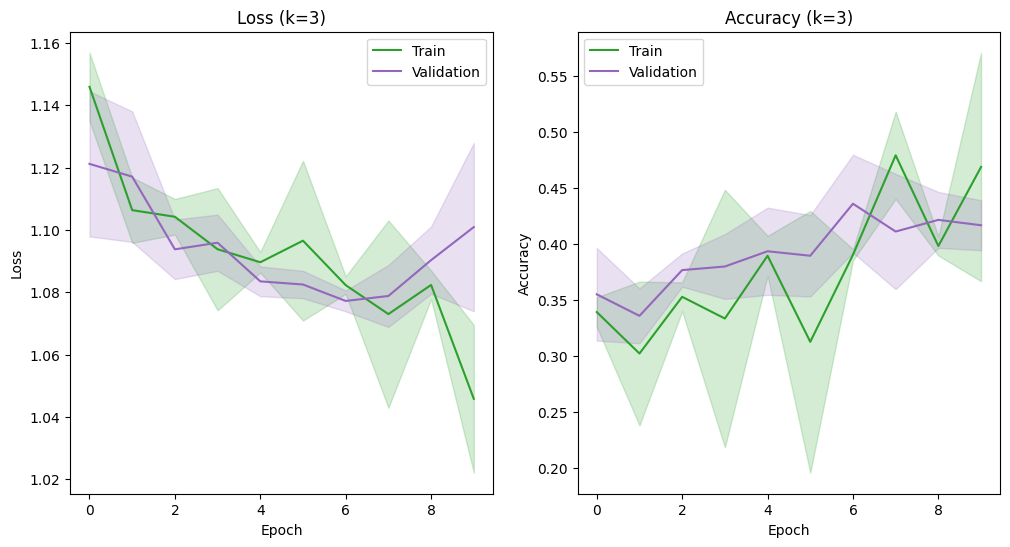

Précision : moyenne=42.460% écart-type=2.833%, k=3


In [10]:
scores, histories = evaluate_model(base_model, X_train, y_train, datagen)
plot_curves(histories)
print(f'Précision : moyenne={mean(scores) * 100:.3f}% écart-type={std(scores) * 100:.3f}%, k={len(scores)}')

In [11]:
# Chargement du modèle sauvegardé
model_filename = "something.keras"
model_path = os.path.join('./data/dataset/Data_sheep_cat_elephant_with_caption_600', model_filename)
model = load_model(model_path)

# Prédiction
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Conversion de y_test
y_true_labels = np.argmax(y_test, axis=1)

# Matrice de confusion
conf = confusion_matrix(y_true_labels, y_pred_labels)


# Affichage
plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vérité terrain")
plt.tight_layout()
plt.show()

ValueError: File not found: filepath=./data/dataset/Data_sheep_cat_elephant_with_caption_600\something.keras. Please ensure the file is an accessible `.keras` zip file.